# Portfolio Optimization

## Overview

In this project, we will build an investment portfolio using Ray Dalio's All Weather Portfolio (AWP) as a benchmark, and optimize it using Markowitz's Modern Portfolio Theory (MPT) and Wiiliam Sharpe's Sharpe Ratio. Our goal is to find the alternate combination of the AWP that minimize risk and maximize returns, and compare it to the original weightings suggested by Ray Dalio.

The "All Weather Portfolio" (AWP) concept originated from Ray Dalio, founder of Bridgewater Associates, the world's largest hedge fund. As the name suggest, this portfolio is designed to weather any storm in the market, and should be easy to manage for an average investor. Below is the allocation of the AWP, along with the ETF's that will be used to replicate each category of the AWP:

1. 30% US stocks (**'SPY'** - SPDR S&P500 ETF Trust)
2. 40% Long-term bonds (**'TLT'** - iShares 20 Plus Year Treasury Bond ETF)
3. 15% Intermediate-term bonds (**'IEI'** - iShares 3-7 Year Treasury Bond ETF)
4. 7.5% Commodities (**'DBC'** - Invesco DB Commodity Index Tracking Fund)
5. 7.5% Gold (**'GLD'** - SPDR Gold Trust)

Markowitz's Modern Portfolio Theory states that risk-averse investors, given a set of portfolios that provide the same expected return, will favor the one with the minimum level of risk. All individual assets' risks and returns have great impacts in the portofolio's profile, which highlights the importance of diversification in assets with little (or negative) correlation in a portfolio.

When every possible combination of the selected assets is plotted in a graph that compares returns vs. volatility (risk), the group of possible portfolio usually forms a bullet shape. The upper left boundary of the bullet shape is also known as the "efficient frontier", which shows the set of portfolios with the highest expected returns and the minimum level of risk. All the portfolios beneath the efficient frontier as deemed as "inefficient".

The last concept that we will use for this project is the Sharpe Ratio (SR). The ratio measures the risk-adjusted returns of a portfolio by substracting the risk-free rate of return from the expected return of a portfolio, and dividing it by the volatility of the portfolio. A higher ratio means higher returns per unit of volatility, hence, the better. A SR above 1 is considered good for investors. We will assume a 0% risk-free rate for this exercise.

In summary, we will build the AWP using its weightings suggested by Ray Dalio, use the MPT and efficient frontier to find a set of "efficient" portfolios, and find the one with the highest Sharpe ratio. This will be our "optimal" portfolio, and we will compare the weightings and performance of the original AWP and the optimized AWP. **Will the optimized AWP perform better that the original AWP?**


### Section 1: Finding the Optimal Portfolio using a Monte Carlo Simulation

First, let's import all the libraries that we need for scraping, synthesizing, and visualizing the stock data.

At the time of doing this project, several free APIs (Yahoo, Google, and Morningstar) were not available to scrape using Pandas_DataReader. A temporary fix for this issue (found on a Stack Overflow forum" is using the "Yfinance" library, which "hijacks" Pandas_DataReader's "get_data_yahoo()" method, and allows us to retrieve the data from Yahoo's API.

In [1]:
# Importing Libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import yfinance as yf
import datetime as dt
from scipy.optimize import minimize
%matplotlib inline

We will create a list with all the ticker symbols mentioned on the overview, and then proceed to scrape the prices of each stock and assign them to a variable.

We'll use the Adjusted Close price for this project, since this reflects the stock's value after accounting for events like stocks splits and dividend payments. 

In [2]:
# Retrieving the data

yf.pdr_override()
stocks = ['SPY','TLT','IEI','GLD','DBC']
start = dt.datetime(2010,1,1)
end = dt.datetime(2021,7,1)

data = pd.DataFrame()
for t in stocks:
    data[t] = web.get_data_yahoo(t,start=start,end=end)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Let's check the integrity of the data:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2893 entries, 2010-01-04 to 2021-06-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     2893 non-null   float64
 1   TLT     2893 non-null   float64
 2   IEI     2893 non-null   float64
 3   GLD     2893 non-null   float64
 4   DBC     2893 non-null   float64
dtypes: float64(5)
memory usage: 135.6 KB


Fortunately we don't have any missing values, and they are all numeric variables.

Now, let's check the structure of the data:

In [4]:
# First five trading days
data.head()

,SPY,TLT,IEI,GLD,DBC
Date,,,,,
2010-01-04,90.493996,65.856651,93.611610,109.800003,24.523520
2010-01-05,90.733574,66.281921,93.908897,109.699997,24.552668
2010-01-06,90.797455,65.394669,93.781517,111.510002,24.989893
2010-01-07,91.180725,65.504692,93.747520,110.820000,24.678976
2010-01-08,91.484131,65.475342,93.883430,111.370003,24.659544


Next, we will calculate the arithmetic returns (AR) of each stock.

In [5]:
# Arithmetic Returns
ar_ret = data/data.shift(1)-1
ar_ret.tail()

,SPY,TLT,IEI,GLD,DBC
Date,,,,,
2021-06-24,0.005916,0.001605,-0.000230,-0.000602,0.003684
2021-06-25,0.003552,-0.010383,-0.000767,0.003312,-0.004195
2021-06-28,0.002016,0.010281,0.001228,-0.000060,-0.000527
2021-06-29,0.000538,0.001673,0.000383,-0.010505,0.004742
2021-06-30,0.000842,0.004453,0.000460,0.004854,0.009439


In stock analysis, logarithmic returns (LR) are also commonly used and usually preferred over AR, especially when it comes to comparing the performance across time periods of a single stock. 

Numpy's 'log' function allows us to obtain the LR easily. In the calculation below, we can see that the difference between both returns is miniscule.

In [6]:
# Logarithmic Returns
log_ret = np.log(data/data.shift(1))
log_ret.tail()

,SPY,TLT,IEI,GLD,DBC
Date,,,,,
2021-06-24,0.005898,0.001604,-0.000230,-0.000602,0.003677
2021-06-25,0.003546,-0.010438,-0.000767,0.003307,-0.004204
2021-06-28,0.002014,0.010229,0.001228,-0.000060,-0.000527
2021-06-29,0.000538,0.001671,0.000383,-0.010561,0.004731
2021-06-30,0.000841,0.004444,0.000460,0.004842,0.009395


However, AR serves the purpose of this project better since it's more suitable for comparing the perfomance among differen portfolios. So, we'll proceed using AR.

#### Monte Carlo Simulation

Next, we will perform a Monte Carlo simulation (MCS) and generate 500,000 random portfolios with different weightings. Feel free to reduce this number depending on your computer's processing power.

First, we will include the "random.seed" function, which generates the same set of random variables (in this case, the weights of each holding) during our simulation. This will allows us to reiterate the simulation using the same set of portfolios, and makes changes to the syntax if needed.
 
We will then create multiple arrays to store the results from our simulation (weights, returns, volatility, and SR).

A few notes about the syntax below:
1. Our weights formula ensures that the sum of all randomly generated weights will always equal to 1.
2. For the returns, we are calculating the annual average return of each stock. 252 is the average number of trading days in a year.
3. The volatility is calculated using linear algebra, and it is annualized as well.
4. Since we are assuming 0% risk-free rate, the SR formula will only consist of the returns divided by the volatility.

In [7]:
# Keep random weights constant
np.random.seed(100)

# Variables
num_ports = 500000
all_weights = np.zeros((num_ports,len(data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

# Monte Carlo simulation
for x in range(num_ports):
    
    #Weights
    weights = np.array(np.random.random(len(data.columns)))
    weights = weights/np.sum(weights)
    all_weights[x,:] = weights
    
    #Expected Return
    ret_arr[x] = np.sum((ar_ret.mean() * weights) * 252)
    
    #Expected Volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T,np.dot(ar_ret.cov() * 252, weights)))
    
    #Sharpe Ratio
    sharpe_arr[x] = ret_arr[x] / vol_arr[x]

Once the simulation is complete, we can check what's the highest SR out of all the portfolios that we generated, and see if our simulation was able to generate a portfolio with great risk-adjusted returns (SR above 1).

In [8]:
print('Highest SR: ',sharpe_arr.max())

if sharpe_arr.max() >= 1:
    print('Good!')
else:
    print('Bad!')

Highest SR:  1.5890679451535141
Good!


We can also visualize all the portfolios in a graph.

We will set the X axis as the volatility, the Y axis as the returns, and color them based on their SR.

We will also plot the portfolio with the highest SR (the optimal portfolio) with a different color to set it apart from the crowd. We can find the return and volatility of this portfolio by looking at the index number of the highest SR, and locate the same index in the 'ret' and  'vol' arrays.

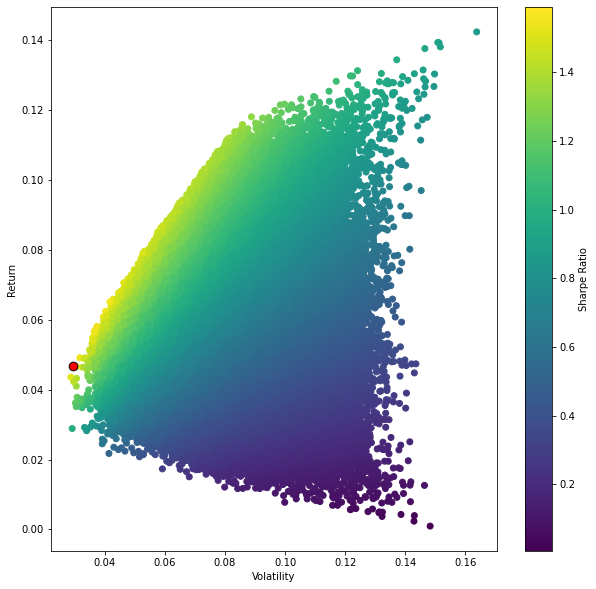

In [9]:
# Returns and Volatility of Optimal Portfolio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

# All portfolios from simulation
plt.figure(figsize=(10,10))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Optimal Portfolio
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=75,edgecolors='black');

The set of portfolios form a distinct parabolic shape, with the "efficient" ones (colored in yellow/green) lying on the upper left edge, on what we know as the efficient frontier. Our optimal portfolio is also located near the frontier.

### Section 2: Finding the Optimal Portfolio using Scipy

Using the Monte Carlo simulation, we were able to find an optimal version of the AWP. However, the simulation only captures 500,000 out of the millions of possible combinations of the AWP. The optimal portfolio (and it's highest SR) we got in the section above is only a close estimate of the "most" optimal portfolio.

The Monte Simulation fails to capture ALL the portfolios lying on the efficient frontier. This will become more evident when we draw the efficient frontier in a later part of this project. To get all those portfolios, it requires to add the number of iterations in our simulation, which would significantly prolong the run time.

Fortunately, we can achieve the same result using Scipy's minimize function, and "hijacking" it to find the combination of AWP holdings that will yield the highest SR.

Let's start by defining a function that uses the same formula that we used in the simulation, and returns an array with the 3 components that we need: returns, volatility, and the SR.

In [10]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(ar_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(ar_ret.cov() * 252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

Now, we need a second function that turns the SR from our funnction above negative. This is how we will "hijack" the Scipy's minimize function to get the portfolio with the highest SR.

In [11]:
# Negative Sharpe Ratio
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

Next, we need to set the arguments for the minimize function.

A few notes about the arguments below:
1. **Constraint**: This will check that our function is always returning 0. By substracting 1 from the sum of the weights, we are making sure that the weights of the holdings add up to 1.
2. **Bounds**: We'll create a tuple of tuples that sets the limits of each holding's weights between 0 and 1.
3. **Initial Guess**: We'll set our initial guess to be an equally distributed portfolio, consisting of 20% for each holding.
4. **Method**: We'll use 'SLSQP' for our method, which is recommended for basic tasks. 'SLSQP' stands for "Sequential Least Square Programming".

In [12]:
# Constraint
def check_sum(weights):
    return np.sum(weights) - 1

cons = ({'type':'eq','fun':check_sum})

# Bounds
a = np.zeros(len(data.columns))
b = np.ones(len(data.columns))
bounds = tuple(zip(a,b))

# Initial Guess
init_guess = list(np.ones(len(data.columns)) *  (1/len(data.columns)))

# Method
meth = 'SLSQP'

#### Scipy's minimize function

Once we define each argument, we can now run the minimize function. 

In [13]:
opt_result = minimize(neg_sharpe
                      ,init_guess
                      ,method=meth
                      ,bounds=bounds
                      ,constraints=cons)
opt_result

     fun: -1.6420523642225493
     jac: array([ 4.41655517e-03,  3.66517752e-02, -7.99417496e-04,  9.21382427e-01,
        2.40090573e+00])
 message: 'Optimization terminated successfully'
    nfev: 96
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([1.53273558e-01, 2.07624716e-16, 8.46726442e-01, 0.00000000e+00,
       2.21667400e-15])

From all the values that we got from the minimize function, we will only focus on 'fun' and 'x'.

'Fun' is the lowest result we can get from the "negative sharpe" function, and 'x' contains the weights of each holding that yielded the lowest SR (or highest, if you look at it the other way around). In other words, 'x' represents our optimal portfolio.

In [14]:
print('Weights of Optimal Portfolio')

for n,m in zip(stocks, opt_result.x):
    print(n,':',round(float(m)*100,3),'%')

Weights of Optimal Portfolio
SPY : 15.327 %
TLT : 0.0 %
IEI : 84.673 %
GLD : 0.0 %
DBC : 0.0 %


We can see that our optimal portfolio is composed of mainly **Intermediate-term Bonds (84.673%)**, a fraction of **US Equity (15.327%)**, tiny fragments of **Long-term bonds and Commodities (~0.000%)**, and no **Gold (0.000%)**.

Now, let's input those weights into the first function to get the returns, volatility, and the SR of this portfolio.

In [15]:
print('Returns: ',get_ret_vol_sr(opt_result.x)[0]*100, '%')
print('Volatility: ',get_ret_vol_sr(opt_result.x)[1])
print('SR: ',get_ret_vol_sr(opt_result.x)[2])

Returns:  4.792706368768402 %
Volatility:  0.02918729312897138
SR:  1.6420523642225493


The SR of the optimal portfolio (**1.589**) from the MCS is not far off the SR of the portfolio (**1.642**) that we got using the minimize function. However, the latter option is preferred for accuracy and efficiency, especially when dealing with portfolios with more holdings than the AWP. 

### Section 3: Plotting the Efficient Frontier

Next, we'll proceed drawing the efficient frontier on the graph that we created on the previous section, and we'll use the minimize function for this purpose as well.

First, we'll create a list of returns that are equally spaced.

Then, we will create a function that minimizes the volatility, and help us find the lowest volatility for each return on our previous list.

We'll use the same arguments that we used in the previous section, with the expection of an additional constraint. The second constraint will make sure that we get highest possible return on each iteration.

Now, let's run the minimize function:

In [16]:
# Returns
frontier_y = np.linspace(0,0.13,100)


# Volatility
def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
           {'type':'eq','fun':lambda w: get_ret_vol_sr(w)[0]-possible_return})
    
    result = minimize(minimize_vol
                      ,init_guess
                      ,method=meth
                      ,bounds=bounds
                      ,constraints=cons)
    
    frontier_volatility.append(result['fun'])

Now that we have the returns and volatility values of the frontier, we can plot it on the graph. We will also plot the optimal portfolio that we found using the minimize function.

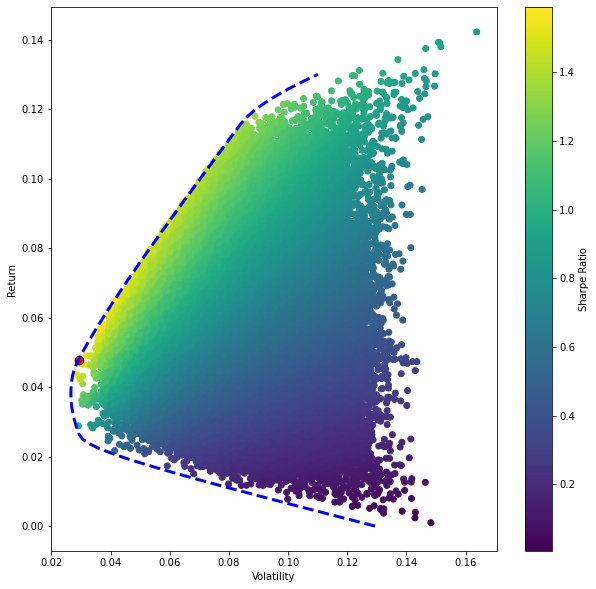

In [17]:
# All portfolios
plt.figure(figsize=(10,10))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Efficient Frontier
plt.plot(frontier_volatility,frontier_y,'b--',lw='3')

# Optimal Portfolio
opt_ret = get_ret_vol_sr(opt_result.x)[0]
opt_vol = get_ret_vol_sr(opt_result.x)[1]

plt.scatter(opt_vol,opt_ret,c='red',s=75,edgecolors='black');

We can see from the graph above, that our optimal portfolio lies right on the efficient frontier! 

We can also observe that there is a blank space between the frontier and the portfolios. This represent the portfolios that the MCS failed to capture.

### Section 4: Comparing the Performance of the Portfolios

Now that we know what are the weights of our optimal AWP, let's compare its performance with the original AWP's. We'll calculate how much we would make if we invested $10,000 in either portfolio on 2010.

We'll start by creating a variable, and normalizing the intiial price of each holding to 1.

In [18]:
# Normalized Data
data2 = data/data.iloc[0]
data2

,SPY,TLT,IEI,GLD,DBC
Date,,,,,
2010-01-04,1.000000,1.000000,1.000000,1.000000,1.000000
2010-01-05,1.002647,1.006458,1.003176,0.999089,1.001189
2010-01-06,1.003353,0.992985,1.001815,1.015574,1.019017
2010-01-07,1.007589,0.994656,1.001452,1.009290,1.006339
2010-01-08,1.010941,0.994210,1.002904,1.014299,1.005547
...,...,...,...,...,...
2021-06-24,4.697549,2.176137,1.391773,1.512204,0.777621
2021-06-25,4.714235,2.153542,1.390705,1.517213,0.774359
2021-06-28,4.723739,2.175682,1.392413,1.517122,0.773951


Next, we will allocate each stock according to the AWP's suggested weights, and convert the portfolio to start at $10,000 instead of 1. We'll assign these values to a new variable to make it easier to work with.

In [19]:
# AWP's weights for each holdings
all_weather_allocation = [0.3,0.4,0.15,0.075,0.075]

# All Weather Portfolio
awp = pd.concat([all_weather_allocation[0]*data2['SPY']
                ,all_weather_allocation[1]*data2['TLT']
                ,all_weather_allocation[2]*data2['IEI']
                ,all_weather_allocation[3]*data2['GLD']
                ,all_weather_allocation[4]*data2['DBC']],axis=1)

awp['Total Pos'] = awp.sum(axis=1)*10000
awp

,SPY,TLT,IEI,GLD,DBC,Total Pos
Date,,,,,,
2010-01-04,0.300000,0.400000,0.150000,0.075000,0.075000,10000.000000
2010-01-05,0.300794,0.402583,0.150476,0.074932,0.075089,10038.744348
2010-01-06,0.301006,0.397194,0.150272,0.076168,0.076426,10010.666081
2010-01-07,0.302277,0.397862,0.150218,0.075697,0.075475,10015.288004
2010-01-08,0.303282,0.397684,0.150436,0.076072,0.075416,10028.903982
...,...,...,...,...,...,...
2021-06-24,1.409265,0.870455,0.208766,0.113415,0.058322,26602.224700
2021-06-25,1.414271,0.861417,0.208606,0.113791,0.058077,26561.609097
2021-06-28,1.417122,0.870273,0.208862,0.113784,0.058046,26680.871011


And we will do the same for the optimal AWP.

In [20]:
# Optimal AWP's weights
opt_allocation = opt_result.x

# Optimal All Weather Portfolio
opt_port = pd.concat([opt_allocation[0]*data2['SPY']
                     ,opt_allocation[1]*data2['TLT']
                     ,opt_allocation[2]*data2['IEI']
                     ,opt_allocation[3]*data2['GLD']
                     ,opt_allocation[4]*data2['DBC']],axis=1)

opt_port['Total Pos'] = opt_port.sum(axis=1)*10000
opt_port

,SPY,TLT,IEI,GLD,DBC,Total Pos
Date,,,,,,
2010-01-04,0.153274,2.076247e-16,0.846726,0.0,2.216674e-15,10000.000000
2010-01-05,0.153679,2.089655e-16,0.849415,0.0,2.219309e-15,10030.947747
2010-01-06,0.153788,2.061682e-16,0.848263,0.0,2.258829e-15,10020.508042
2010-01-07,0.154437,2.065151e-16,0.847956,0.0,2.230726e-15,10023.924630
2010-01-08,0.154951,2.064226e-16,0.849185,0.0,2.228969e-15,10041.356743
...,...,...,...,...,...,...
2021-06-24,0.720010,4.518199e-16,1.178451,0.0,1.723732e-15,18984.610082
2021-06-25,0.722568,4.471285e-16,1.177547,0.0,1.716501e-15,19001.145116
2021-06-28,0.724024,4.517254e-16,1.178993,0.0,1.715597e-15,19030.175784


Now that we have created both portfolios, we can plot them in a graph to visually compare their performance.

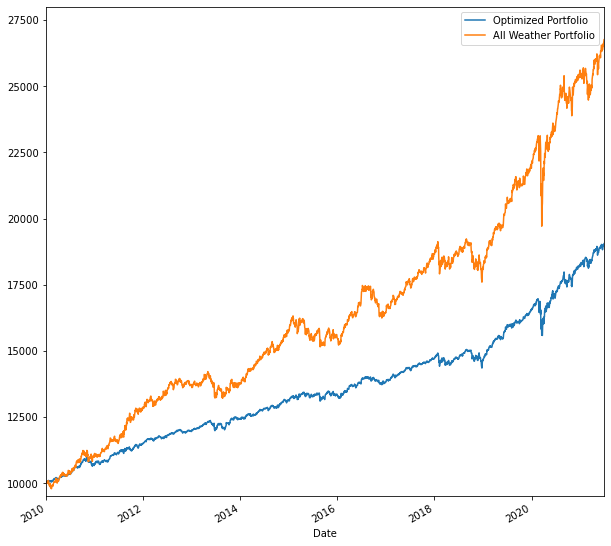

In [21]:
# Optimal AWP
opt_port['Total Pos'].plot(figsize=(10,10)
                           ,label='Optimized Portfolio'
                           ,xlim=['2010-01-01','2021-06-30']
                           ,ylim=[9500,28000])
# Original AWP
awp['Total Pos'].plot(label='All Weather Portfolio')
plt.legend();

We can see that the optimal AWP overall performed worse than the original AWP. However, the optimal AWP seems to have less abrupt fluctuations than the original AWP. This is a reasonable expectation since Markowitz's MPT and William Sharpe's SR that seek to minimize risk, which also reduce potential returns.

Even with an overall worse performance, we can observe (hardly) that the optimal AWP did outperform the original AWP for a short period of time at the beginning of our investing horizon.

To visualize this better, we'll calculate and see which days the optimal AWP performed better, zoom in on the graph, and plot these "positive" days on it.

Let's start by creating a new dataframe with the info that we need.

In [22]:
# Variance Between Optimal AWP and Original AWP
var = pd.concat([opt_port['Total Pos'],awp['Total Pos']],axis=1)
var.columns = ['Opt','Awp']
var['Diff'] = opt_port['Total Pos'] - awp['Total Pos']
var

,Opt,Awp,Diff
Date,,,
2010-01-04,10000.000000,10000.000000,5.456968e-12
2010-01-05,10030.947747,10038.744348,-7.796601e+00
2010-01-06,10020.508042,10010.666081,9.841961e+00
2010-01-07,10023.924630,10015.288004,8.636626e+00
2010-01-08,10041.356743,10028.903982,1.245276e+01
...,...,...,...
2021-06-24,18984.610082,26602.224700,-7.617615e+03
2021-06-25,19001.145116,26561.609097,-7.560464e+03
2021-06-28,19030.175784,26680.871011,-7.650695e+03


Next, we'll extract the days where the optimal AWP outperformed the original one.

In [23]:
# Days of positive performance
var[var['Diff']>0].index

DatetimeIndex(['2010-01-04', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15', '2010-01-19', '2010-01-20', '2010-01-21',
               '2010-01-22', '2010-01-25', '2010-01-26', '2010-01-27',
               '2010-01-28', '2010-01-29', '2010-02-01', '2010-02-02',
               '2010-02-03', '2010-02-04', '2010-02-05', '2010-02-08',
               '2010-02-09', '2010-02-10', '2010-02-11', '2010-02-12',
               '2010-02-16', '2010-02-17', '2010-02-18', '2010-02-19',
               '2010-02-22', '2010-02-23', '2010-02-24', '2010-02-25',
               '2010-02-26', '2010-03-01', '2010-03-02', '2010-03-03',
               '2010-03-04', '2010-03-05', '2010-03-08', '2010-03-09',
               '2010-03-10', '2010-03-11', '2010-03-12', '2010-03-15',
               '2010-03-16', '2010-03-17', '2010-03-18', '2010-03-19',
               '2010-03-22', '2010-03-23', '2010-03-24', '2010-03-25',
      

Once we have all the information we need, we can now plot it on the graph. We'll zoom on the first 8 months of our investing period, and put a distinct money green color on the days where the optimal AWP performed better.

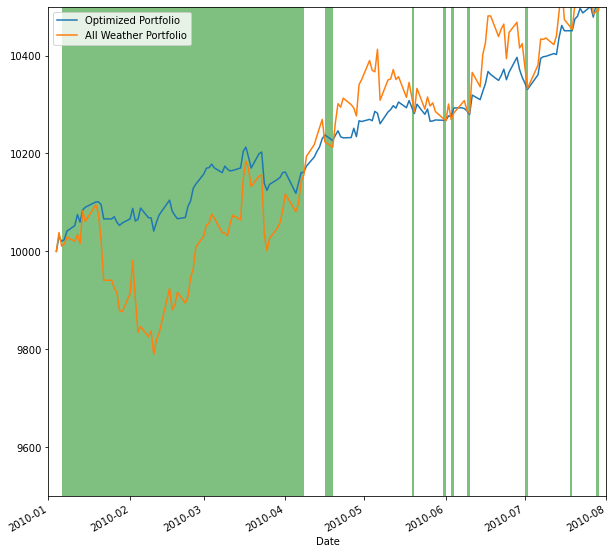

In [24]:
# Optimal AWP
opt_port['Total Pos'].plot(figsize=(10,10)
                           ,label='Optimized Portfolio'
                           ,xlim=['2010-01-01','2010-08-01']
                           ,ylim=[9500,10500])

# Original AWP
awp['Total Pos'].plot(label='All Weather Portfolio')
plt.legend();


# Positive days
plt.axvspan('2010-01-06', '2010-04-08', facecolor='g', alpha=0.5)
plt.axvspan('2010-04-16', '2010-04-19', facecolor='g', alpha=0.5)
plt.axvspan('2010-05-19', '2010-05-20', facecolor='g', alpha=0.5)
plt.axvspan('2010-05-31', '2010-06-01', facecolor='g', alpha=0.5)
plt.axvspan('2010-06-03', '2010-06-04', facecolor='g', alpha=0.5)
plt.axvspan('2010-06-09', '2010-06-10', facecolor='g', alpha=0.5)
plt.axvspan('2010-07-01', '2010-07-02', facecolor='g', alpha=0.5)
plt.axvspan('2010-07-18', '2010-07-19', facecolor='g', alpha=0.5)
plt.axvspan('2010-07-28', '2010-07-29', facecolor='g', alpha=0.5);

Even though it was only a brief period (around 4 months), we can observe that the optimal AWP did benefit from the reduced volatility from our calculation. 

### Conclusion

In conclusion, the worse performance of this portofolio might not attract a lot of risk-seeking investors that are looking to maximize their gains, but it is worth considering for the risk-averse investors that cannot stomach the volatility of the general market. The reduced volatility can increase the probability of the risk-averse investors holding and not selling during periods of extreme downturns like the one we experienced on March 2020. This is turn can be translated into higher returns, especially compared to the average investor that tends to sell in periods like this.

To finish this, let's compare both portfolios' overall performance to the general market just for fun. Which one of these options would you invest in (after factoring in your risk tolerance)?

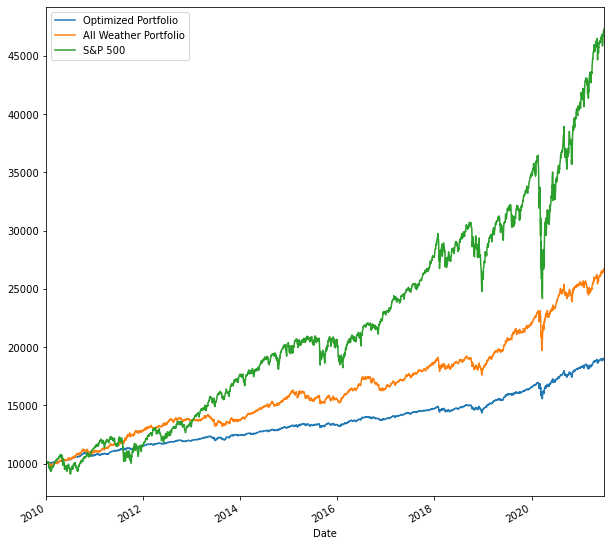

In [25]:
# Optimal AWP
opt_port['Total Pos'].plot(figsize=(10,10)
                           ,label='Optimized Portfolio'
                           ,xlim=['2010-01-01','2021-06-30'])
# Original AWP
awp['Total Pos'].plot(label='All Weather Portfolio')

# General Market - S&P 500
(data2['SPY']*10000).plot(label='S&P 500')

plt.legend();